### Groceries Demand Forecasting using Time Series

**Goal:** <br />
In this project I will implement a time series machine learning model which will predict the demand for grocery items. I will be using the statsmodels.tsa package mainly in my project. 

**Dataset:**<br />
I will be using the <a href='https://fred.stlouisfed.org/series/RSGCSN'>Advanced Retail Sales: Grocery Stores</a> data published by <a href='https://fred.stlouisfed.org/'>Fred Economic Data - St. Louis Fed</a> for my analysis. 
This dataset contains sales in millions of dollars since Jan, 1992 until Mar, 2023 at a monthly frequency. This data is <u>not</u> seasonally adjusted. 

**Highlevel Approach:**
* I will split the data into training and test sets: data from Jan, 1992 - Dec, 2016 will make up the training set, and data from Jan, 2017 - Mar, 2023 will make up the test dataset. 
* I will build a time series model using the statsmodels.tsa libraries and train it on the training set. I will tests its performance against the test set. 
    * The model will be built by analyzing the trend, seasonality, and cycles in the data. 
* At the end, I will compare the time series model against a linear regression model.  


### Import and setup

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.seasonal import _extrapolate_trend

### Data

In [78]:
### Load the data from the csv file into a dataframe
groceries = pd.read_csv('Data/RSGCSN.csv')
groceries

,DATE,RSGCSN
0,1992-01-01,27306
1,1992-02-01,26223
2,1992-03-01,27235
3,1992-04-01,27588
4,1992-05-01,28883
...,...,...
370,2022-11-01,73388
371,2022-12-01,77309
372,2023-01-01,71172
373,2023-02-01,66326


In [79]:
### Convert the date column into a datetime type
groceries['DATE'] = pd.to_datetime(groceries['DATE'])

In [80]:
### Rename the columns into something more meaningful 
groceries.rename(columns={
    'DATE': 'Date',
    'RSGCSN': 'Value'
}, inplace=True)
groceries

,Date,Value
0,1992-01-01,27306
1,1992-02-01,26223
2,1992-03-01,27235
3,1992-04-01,27588
4,1992-05-01,28883
...,...,...
370,2022-11-01,73388
371,2022-12-01,77309
372,2023-01-01,71172
373,2023-02-01,66326


In [81]:
groceries.set_index('Date', inplace=True)
groceries

,Value
Date,
1992-01-01,27306
1992-02-01,26223
1992-03-01,27235
1992-04-01,27588
1992-05-01,28883
...,...
2022-11-01,73388
2022-12-01,77309
2023-01-01,71172


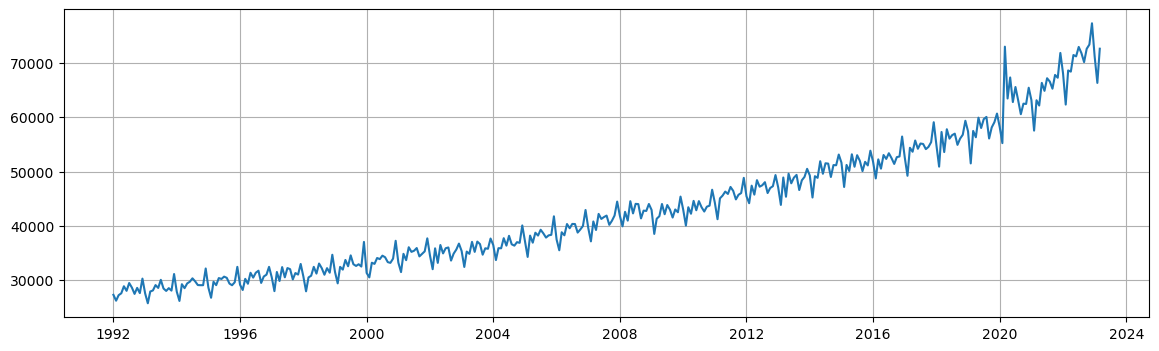

In [82]:
### Let us plot the data and see what we are dealing with
plt.figure(figsize=(14,4))
plt.plot(groceries['Value'])
plt.grid()

#### Data Observations: 
* From the plot above we can see: 
    * a clear upward trend, 
    * A seasonality which repeats in 12 months (1 year) cycle, and 
    * We see a spike in 2020 followed by a steeper trend in the following months.  

#### Stationarity of data

In [83]:
# Let's test the stationarity of the data
adfuller_results = adfuller(groceries)
adfuller_results

(4.225694915695149,
 1.0,
 16,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 6090.199576358882)

In [84]:
isStationary = 'yes' if adfuller_results[1] < 0.05 else 'no' 
print(f'Is the model stationary? {isStationary}')

Is the model stationary? no


#### The data is not stationary. This is good. We can now proceed with our time series analysis. 

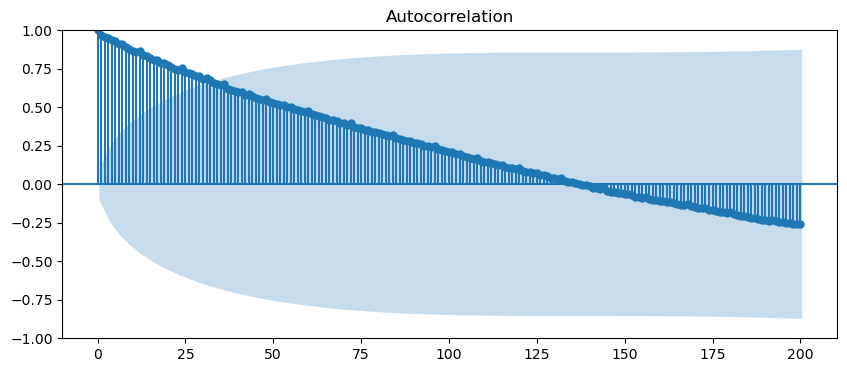

In [85]:
### Let's see the autocorrelation function of the data: 
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(groceries, lags=200, ax=ax)
plt.show()

We see above that the auto correlations do not die down 

In [86]:
### Let us check the difference
groeries_diff = groceries.diff().dropna()

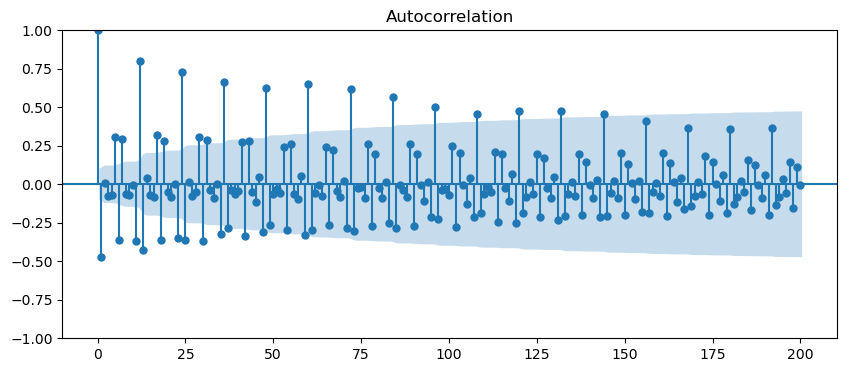

In [87]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(groeries_diff, lags=200, ax=ax)
plt.show()

Even the difference is not stationary. 

### Model

#### Let us decompose the series

In [88]:
### Split into historical and future data
y_hist = groceries.loc['1992':'2016', 'Value']
y_future = groceries.loc['2017':, 'Value']

In [89]:
y_hist, y_future

(Date
 1992-01-01    27306
 1992-02-01    26223
 1992-03-01    27235
 1992-04-01    27588
 1992-05-01    28883
               ...  
 2016-08-01    52475
 2016-09-01    51407
 2016-10-01    52659
 2016-11-01    52780
 2016-12-01    56452
 Name: Value, Length: 300, dtype: int64,
 Date
 2017-01-01    52566
 2017-02-01    49226
 2017-03-01    54383
 2017-04-01    53651
 2017-05-01    55724
               ...  
 2022-11-01    73388
 2022-12-01    77309
 2023-01-01    71172
 2023-02-01    66326
 2023-03-01    72627
 Name: Value, Length: 75, dtype: int64)

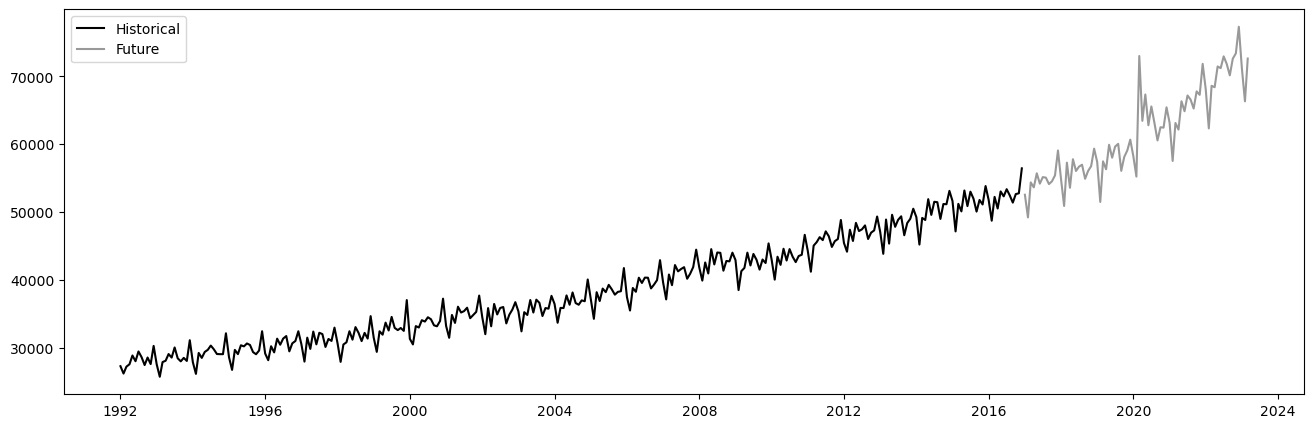

In [90]:
### Let us plot the training (historical) and test (future) data. 
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='Historical')
plt.plot(y_future, 'k', alpha=0.4, label='Future')
plt.legend()

#### Extract the trend

In [91]:
### By eyeballing the graph, we can see that the period is 1 year: 12 months
period = 12
filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period
filt

array([0.04166667, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.04166667])

In [92]:
### Extrapolate the trend
trend = convolution_filter(y_hist, filt)
trend = _extrapolate_trend(trend, period+1)
trend

Date
1992-01-01    27926.026557
1992-02-01    27954.244963
1992-03-01    27982.463370
1992-04-01    28010.681777
1992-05-01    28038.900183
                  ...     
2016-08-01    52167.870192
2016-09-01    52228.929487
2016-10-01    52289.988782
2016-11-01    52351.048077
2016-12-01    52412.107372
Name: Value, Length: 300, dtype: float64

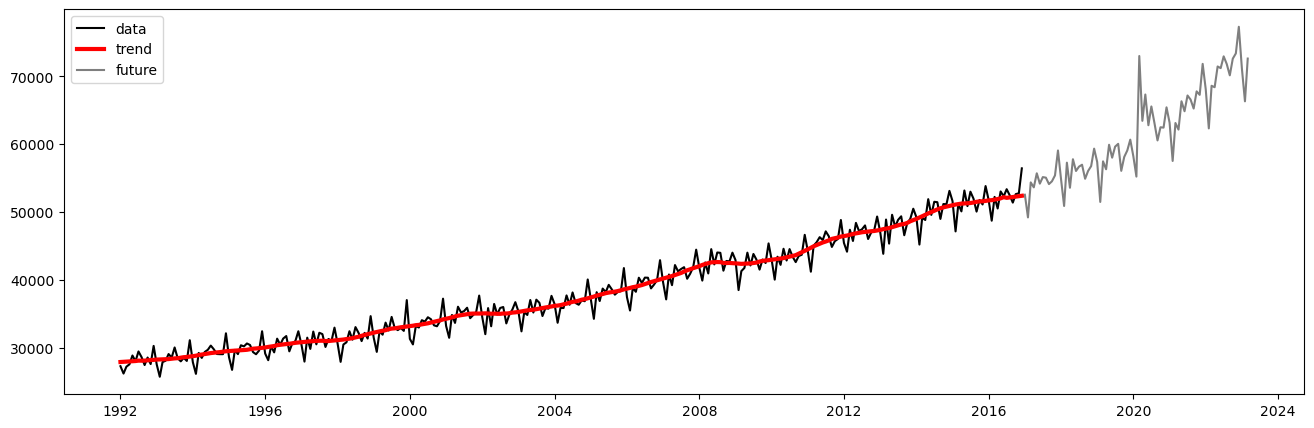

In [93]:
### Plot the trend against the historical and future data
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data')
plt.plot(trend, 'r', linewidth=3, label='trend')
plt.plot(y_future, 'k', alpha=0.5, label='future')
plt.legend()

Our extrapolated trend fits very well against the historical trend. 

#### Split the historical data into seasons

In [94]:
# We know that the lows occur in the month of February every year
lows = y_hist[y_hist.index.month == 2].index
# With some help from Excel I was able to identify the indexes corresponding to February observations
lows_index = [1, 13, 25, 37, 49, 61, 73, 85, 97, 109, 121, 133, 145, 157, 169, 181, 193, 205, 217, 229, 241, 253, 265, 277, 289]
lows

DatetimeIndex(['1992-02-01', '1993-02-01', '1994-02-01', '1995-02-01',
               '1996-02-01', '1997-02-01', '1998-02-01', '1999-02-01',
               '2000-02-01', '2001-02-01', '2002-02-01', '2003-02-01',
               '2004-02-01', '2005-02-01', '2006-02-01', '2007-02-01',
               '2008-02-01', '2009-02-01', '2010-02-01', '2011-02-01',
               '2012-02-01', '2013-02-01', '2014-02-01', '2015-02-01',
               '2016-02-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

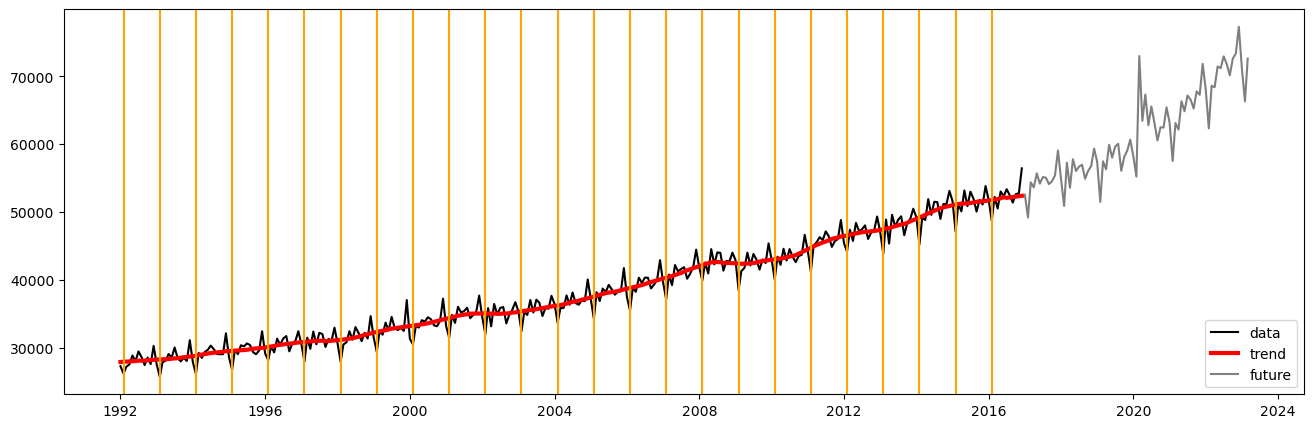

In [95]:
### Let us plot the data, future, and trend and lay the vertical grid lines for the seasons
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data')
plt.plot(trend, 'r', linewidth=3, label='trend')
plt.plot(y_future, 'k', alpha=0.5, label='future')
for low in lows: 
    plt.axvline(x=pd.to_datetime(low), color='orange')
plt.legend()

#### Let's divide the detrended data into seasons

In [96]:
period = 12 #We know that our period is 1 year, or 12 months. 
num_seasons = len(lows)-1
(period, num_seasons)

(12, 24)

In [97]:
### Detrended list is nothing but the historical data minus the trend
detrended = y_hist - trend
detrended = detrended.to_numpy()
detrended

array([-6.20026557e+02, -1.73124496e+03, -7.47463370e+02, -4.22681777e+02,
        8.44099817e+02, -2.81185897e+01,  1.35379167e+03,  5.28541667e+02,
       -6.49833333e+02,  4.08166667e+02, -5.85541667e+02,  2.05720833e+03,
       -7.12666667e+02, -2.55287500e+03, -4.05375000e+02, -2.25041667e+02,
        7.41875000e+02,  1.67750000e+02,  1.61058333e+03, -1.74583333e+01,
       -5.39500000e+02, -1.03125000e+02, -5.84250000e+02,  2.40629167e+03,
       -8.95958333e+02, -2.67658333e+03,  3.09333333e+02, -4.90458333e+02,
        3.18250000e+02,  5.53250000e+02,  1.10291667e+03,  4.95625000e+02,
       -2.37458333e+02, -3.02291667e+02, -3.68583333e+02,  2.64416667e+03,
       -9.12916667e+02, -2.81958333e+03,  8.81666667e+01, -5.44875000e+02,
        7.35000000e+02,  5.40833333e+02,  9.30625000e+02,  6.28458333e+02,
       -5.09458333e+02, -8.52583333e+02, -3.53000000e+02,  2.43129167e+03,
       -8.90875000e+02, -1.95670833e+03,  3.77083333e+01, -9.35083333e+02,
        9.59875000e+02,  

In [98]:
y_hist - trend

Date
1992-01-01    -620.026557
1992-02-01   -1731.244963
1992-03-01    -747.463370
1992-04-01    -422.681777
1992-05-01     844.099817
                 ...     
2016-08-01     307.129808
2016-09-01    -821.929487
2016-10-01     369.011218
2016-11-01     428.951923
2016-12-01    4039.892628
Name: Value, Length: 300, dtype: float64

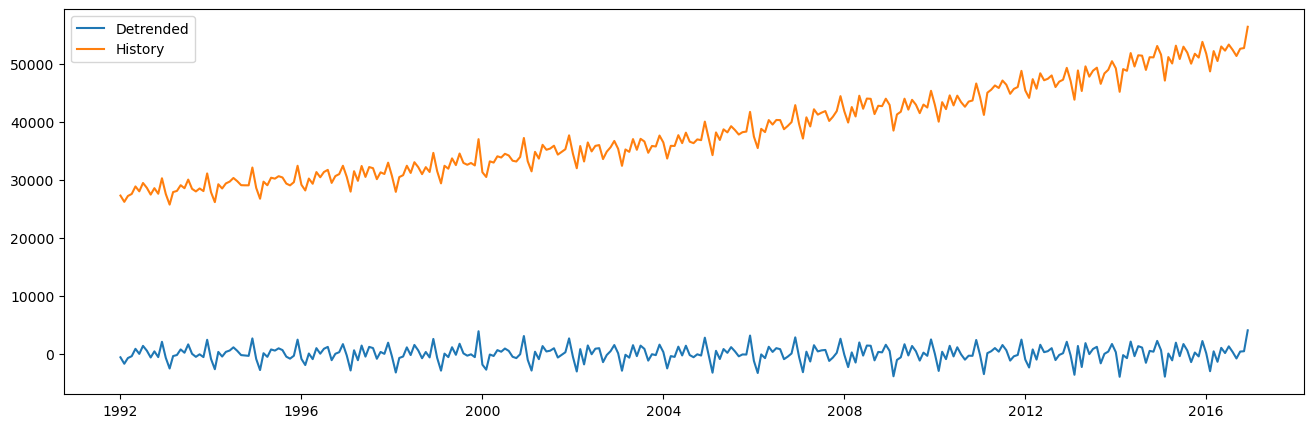

In [99]:
### Let us plot the historical data against the detrended data
plt.figure(figsize=(16,5))
plt.plot(y_hist - trend, label='Detrended')
plt.plot(y_hist, label='History')
plt.legend()

As we can see, the detrended plot is nothing but the projection of the historical plot on the x-axis with a 0 mean. 

In [100]:
### Now, let us extract the seasonals 
seasonals = np.empty((period,num_seasons)) # Create a matrix of 12 rows and 24 columns
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period] #Extract the season
    #s = 2*(s-np.min(s))/(np.max(s)-np.min(s)) #scale it
    seasonals[:,p] = s

mean_seasonals = seasonals.mean(axis=1)

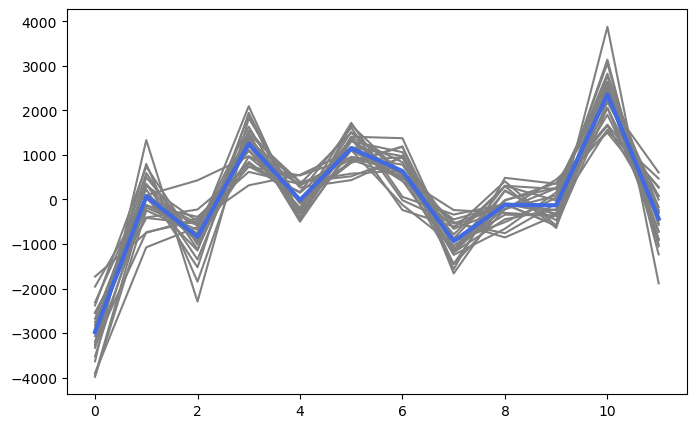

In [101]:
plt.figure(figsize=(8,5))
for p in range(num_seasons): 
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))

plt.plot(mean_seasonals, color='royalblue', linewidth=3)

#### Let us now build the seasonal template

In [102]:
seasonal = pd.Series(index=y_hist.index, data=0)

for low in lows_index: 
    if(low+period<len(seasonal)):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]

#seasonal = seasonal / np.max(seasonal)

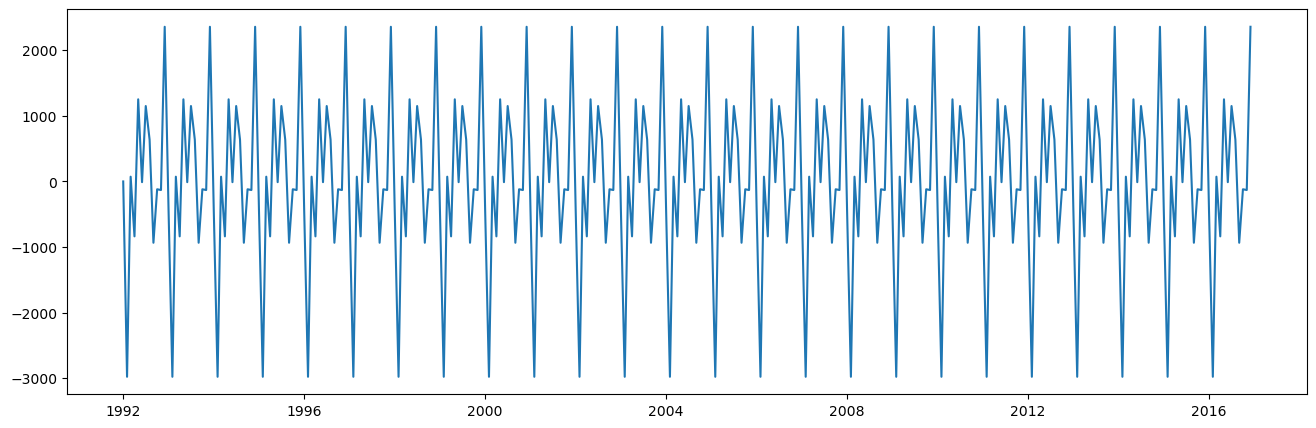

In [103]:
plt.figure(figsize=(16,5))
plt.plot(seasonal)

#### Final Model

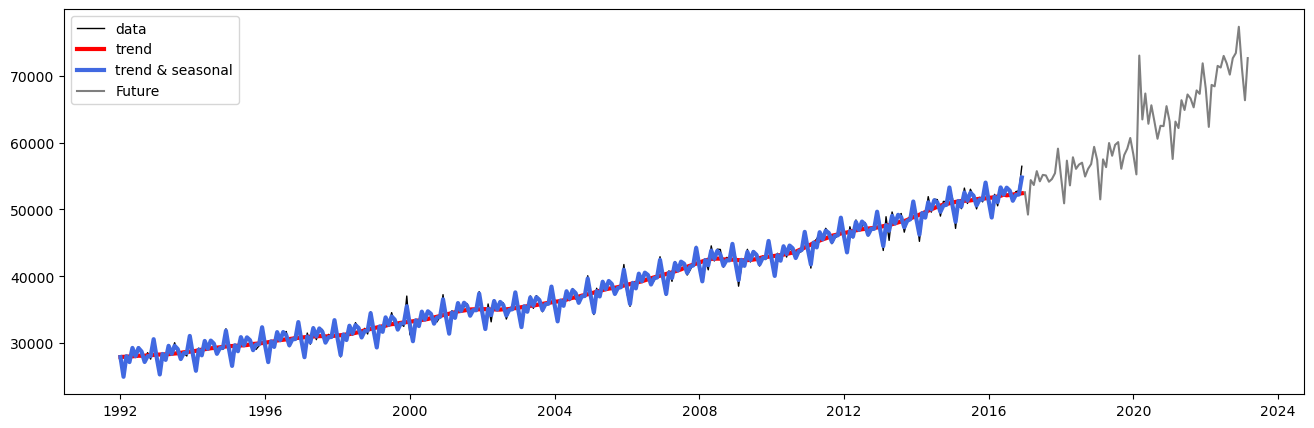

In [104]:
season_and_trend = trend + seasonal
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data', linewidth=1)
plt.plot(trend, label='trend', linewidth=3, color=[1,0,0])
plt.plot(season_and_trend, label='trend & seasonal', color='royalblue', linewidth=3)
plt.plot(y_future, 'k', alpha=0.5, label='Future')
plt.legend(loc='best')

#### Model residue

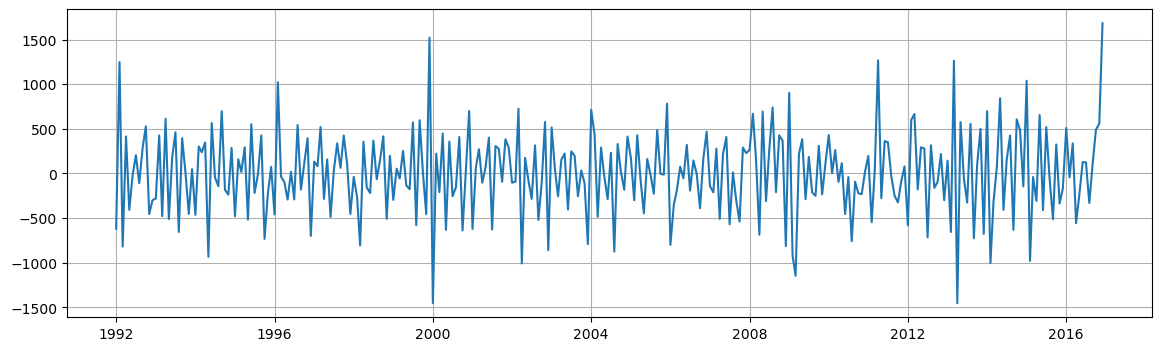

In [105]:
residue = y_hist - season_and_trend
plt.figure(figsize=(14,4))
plt.plot(residue)
plt.grid()

In [106]:
### Let us look at the mean absolute error and the root mean square error of the residue: 
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt(np.square(residue).mean())

print(MAEm)
print(RMSEm)

366.2869072420637
467.2258591699299


#### Stationarity of residue

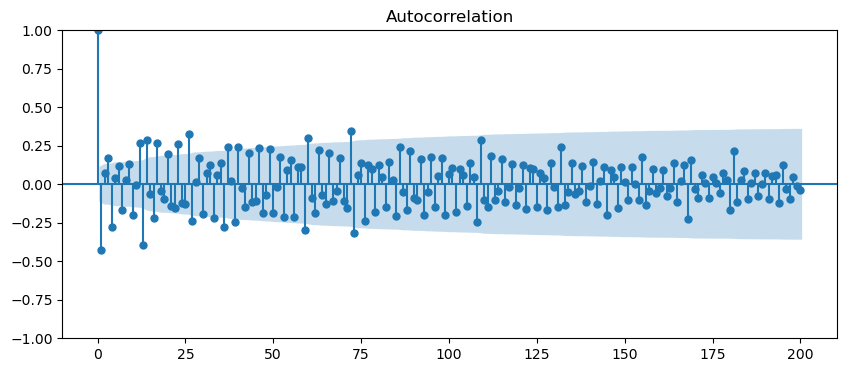

In [107]:
_, ax = plt.subplots(figsize =(10,4))
tsaplots.plot_acf(residue, lags=200, ax=ax)
plt.show()

#### Forecast

Let us now forecast for the future

In [108]:
### Let us first forecast with an assumption that the trend will flatline in the future: 
yhat_trend = pd.Series(index = y_future.index, data=trend[-1]) # Get the last value of trend as we predict that trend will flatlinein the future
yhat_seasonal = pd.Series(index = y_future.index)

for i in range(len(yhat_seasonal)):
   seasonal_index = -(2*len(mean_seasonals)-i)
   yhat_seasonal[i] = seasonal[seasonal_index]

yhat = yhat_seasonal+yhat_trend

C:\Users\ashwi\AppData\Local\Temp\ipykernel_13332\2162582900.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yhat_seasonal = pd.Series(index = y_future.index)


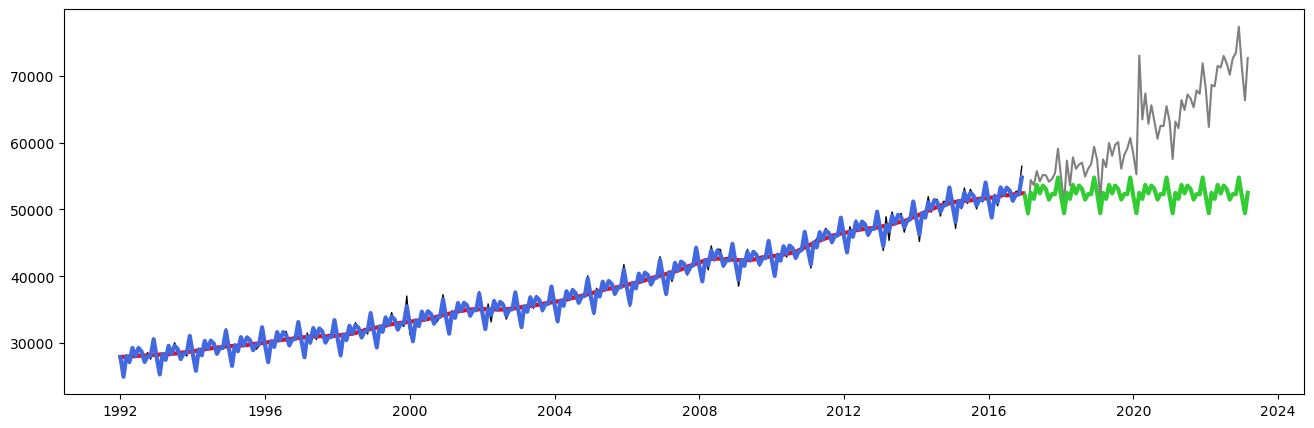

In [109]:
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data', linewidth=1)
plt.plot(trend, label='trend', linewidth=3, color=[1,0,0])
plt.plot(season_and_trend, label='trend & seasonal', color='royalblue', linewidth=3)
plt.plot(y_future, 'k', alpha=0.5, label='Future')
plt.plot(yhat, label='Forecast', color='limegreen', linewidth=3)
# plt.legend(loc='best')

Let us now see what the prediction error is

In [110]:
prediction_errors = []

In [111]:
pred_error = y_future - yhat

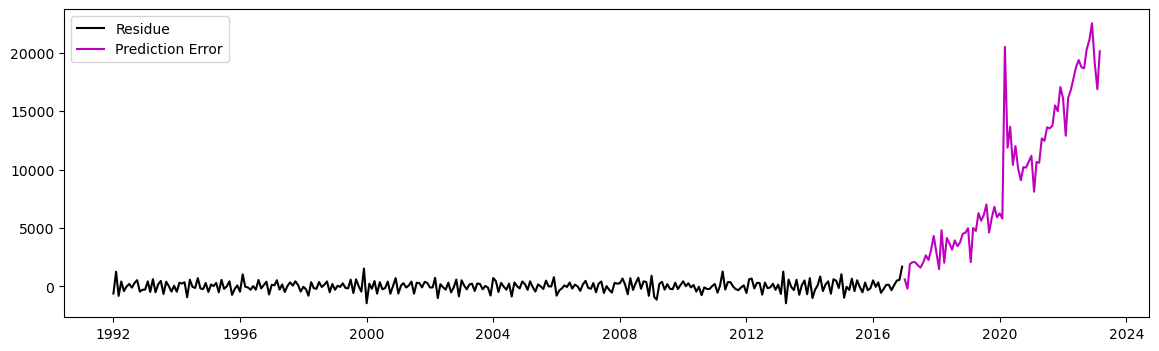

In [112]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k', label='Residue')
plt.plot(pred_error,'m', label='Prediction Error')
plt.legend()

In [113]:
### Size of the prediction error
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
prediction_errors.append(['Time Series - Flat Trend Projected', MAEp, RMSEp])
prediction_errors

[['Time Series - Flat Trend Projected', 9233.930980362238, 11175.237915076861]]

As we can see, the assumption that trend will flatline in the future was a bad assumption. 
So, let us forecast the trendline using a simple linear regression model: 

In [114]:
from sklearn.linear_model import LinearRegression

In [115]:
### Since linear regression does not work with datetime objects, let us breakdown our date into year, month and day numerica values: 
trend_df = pd.DataFrame(trend)
trend_df.reset_index(inplace=True)
trend_df['year'] = trend_df['Date'].dt.year
trend_df['month'] = trend_df['Date'].dt.month
trend_df['day'] = trend_df['Date'].dt.day
trend_df

,Date,Value,year,month,day
0,1992-01-01,27926.026557,1992,1,1
1,1992-02-01,27954.244963,1992,2,1
2,1992-03-01,27982.463370,1992,3,1
3,1992-04-01,28010.681777,1992,4,1
4,1992-05-01,28038.900183,1992,5,1
...,...,...,...,...,...
295,2016-08-01,52167.870192,2016,8,1
296,2016-09-01,52228.929487,2016,9,1
297,2016-10-01,52289.988782,2016,10,1
298,2016-11-01,52351.048077,2016,11,1


In [116]:
### Let us fit the LR model
lr = LinearRegression()
lr.fit(trend_df[['year', 'month', 'day']], trend_df['Value'])

LinearRegression()

In [117]:
### We breakdown the y_future date index into year, month and date fields
y_future_ds = pd.DataFrame(y_future)
y_future_ds.reset_index(inplace=True)
y_future_ds['year'] = y_future_ds['Date'].dt.year
y_future_ds['month'] = y_future_ds['Date'].dt.month
y_future_ds['day'] = y_future_ds['Date'].dt.day
y_future_ds

,Date,Value,year,month,day
0,2017-01-01,52566,2017,1,1
1,2017-02-01,49226,2017,2,1
2,2017-03-01,54383,2017,3,1
3,2017-04-01,53651,2017,4,1
4,2017-05-01,55724,2017,5,1
...,...,...,...,...,...
70,2022-11-01,73388,2022,11,1
71,2022-12-01,77309,2022,12,1
72,2023-01-01,71172,2023,1,1
73,2023-02-01,66326,2023,2,1


In [118]:
### All set, let us predict the trend into the future:
trend_predicted = lr.predict(y_future_ds[['year', 'month', 'day']])
trend_predicted

array([51203.53701401, 51285.30383369, 51367.07065338, 51448.83747307,
       51530.60429275, 51612.37111244, 51694.13793213, 51775.90475181,
       51857.6715715 , 51939.43839119, 52021.20521087, 52102.97203056,
       52228.7029007 , 52310.46972039, 52392.23654007, 52474.00335976,
       52555.77017945, 52637.53699913, 52719.30381882, 52801.07063851,
       52882.83745819, 52964.60427788, 53046.37109757, 53128.13791725,
       53253.86878739, 53335.63560708, 53417.40242677, 53499.16924645,
       53580.93606614, 53662.70288583, 53744.46970551, 53826.2365252 ,
       53908.00334489, 53989.77016457, 54071.53698426, 54153.30380395,
       54279.03467409, 54360.80149377, 54442.56831346, 54524.33513315,
       54606.10195283, 54687.86877252, 54769.63559221, 54851.40241189,
       54933.16923158, 55014.93605127, 55096.70287095, 55178.46969064,
       55304.20056078, 55385.96738047, 55467.73420015, 55549.50101984,
       55631.26783953, 55713.03465921, 55794.8014789 , 55876.56829859,
      

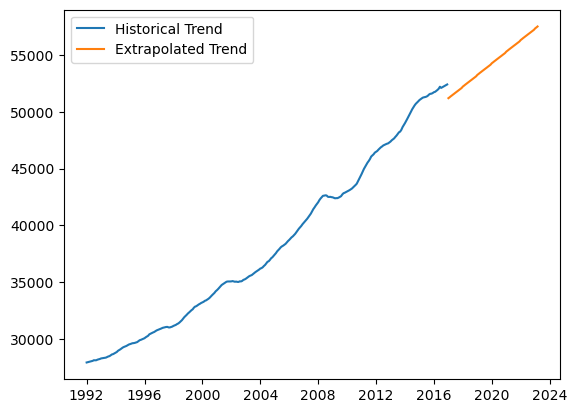

In [119]:
plt.plot(trend, label='Historical Trend')
plt.plot(y_future_ds['Date'], trend_predicted, label='Extrapolated Trend')
plt.legend()

Not a bad prediction of the trend line at all!! 

#### Now, let's recalculate the yhat_trend and forecast again, this time using the predicted trend line

In [120]:
yhat_trend = pd.Series(index = y_future.index) 
for i in range(len(trend_predicted)):
   yhat_trend[i] = trend_predicted[i]

yhat = yhat_seasonal+yhat_trend

C:\Users\ashwi\AppData\Local\Temp\ipykernel_13332\1973866632.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yhat_trend = pd.Series(index = y_future.index)


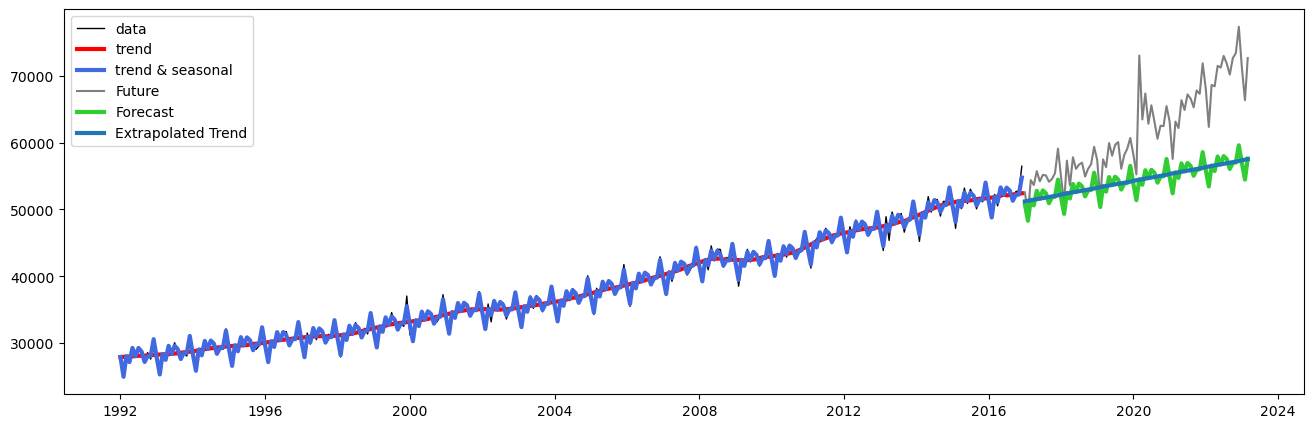

In [121]:
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data', linewidth=1)
plt.plot(trend, label='trend', linewidth=3, color=[1,0,0])
plt.plot(season_and_trend, label='trend & seasonal', color='royalblue', linewidth=3)
plt.plot(y_future, 'k', alpha=0.5, label='Future')
plt.plot(yhat, label='Forecast', color='limegreen', linewidth=3)
plt.plot(y_future_ds['Date'], trend_predicted, linewidth=3, label='Extrapolated Trend')
plt.legend()
# plt.legend(loc='best')

This looks like not a bad prediction at all. The trend looks to continue with the same slope as historical trend, and the seasons repreat accordingly as well. <br />
However, our prediction does not aligh with the actual future values. <br />
Let us calculate the error: 

### Prediction Error


In [122]:
pred_error = y_future - yhat

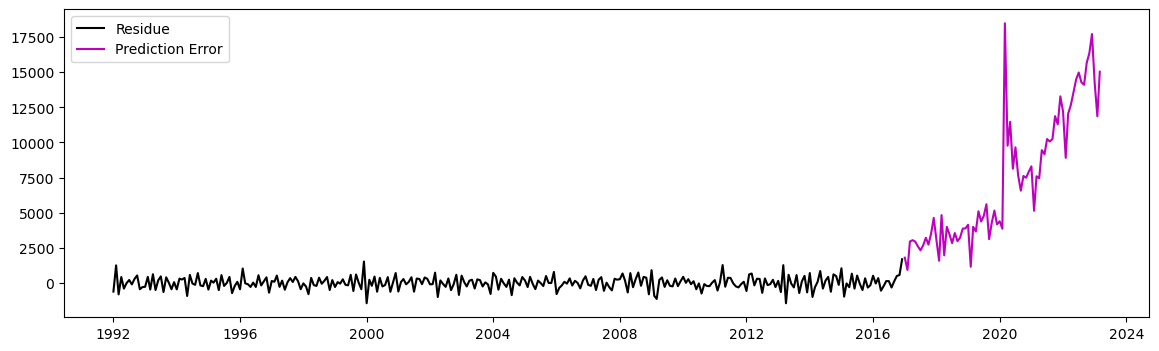

In [123]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k', label='Residue')
plt.plot(pred_error,'m', label='Prediction Error')
plt.legend()

In [124]:
### Size of the prediction error
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
prediction_errors.append(['Time Series - LR Projected Trend W/O Residue', MAEp, RMSEp])
prediction_errors

[['Time Series - Flat Trend Projected', 9233.930980362238, 11175.237915076861],
 ['Time Series - LR Projected Trend W/O Residue',
  7295.517158813891,
  8631.105856181324]]

The errors seem to be a bit high. 

#### ARMA Process

Let us use the ARMA process to predict the future residue and see if addition of this predicted residue will reduce the error: 

In [125]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [126]:
### Let us first check to see if the residue is stationary

residue_stationarity = adfuller(residue)

print(f'Reside is stationary: {"yes" if residue_stationarity[1] < 0.05 else "no"}')

Reside is stationary: yes


Now that we know our residue is stationary, let us go ahead and apply the ARMA model on it

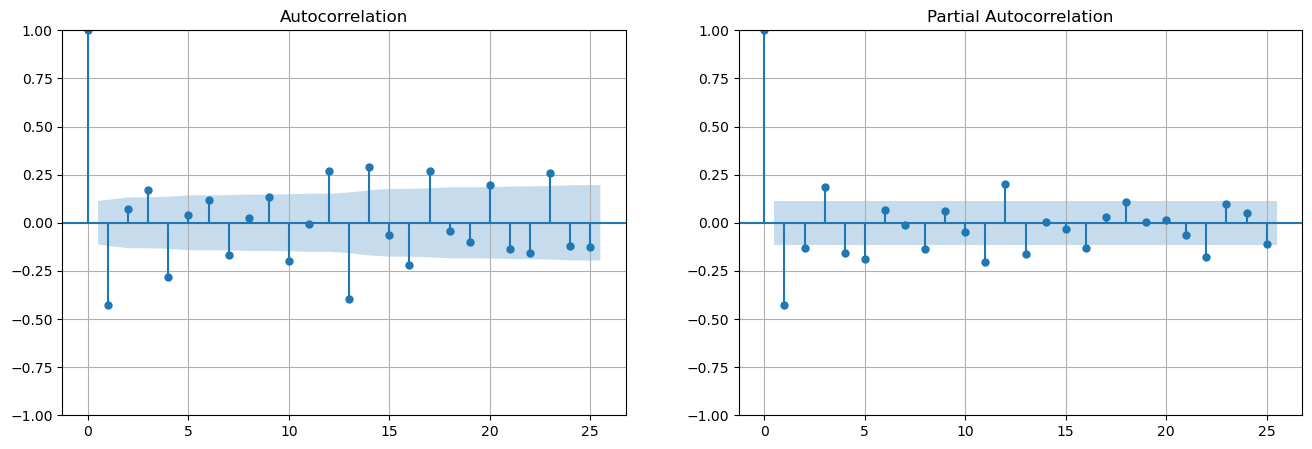

In [127]:
### Let's plot the ACF and PACF plots first: 
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(residue, ax = ax[0]);
ax[0].grid()
plot_pacf(residue, ax = ax[1], method = 'ywm');
ax[1].grid()

The PACF suggests that we should use a value of `p=1` in the ARMA model. Let us go with `p = 1` and `q = 1`

In [128]:
arma = ARIMA(residue,order=(1,0,1)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


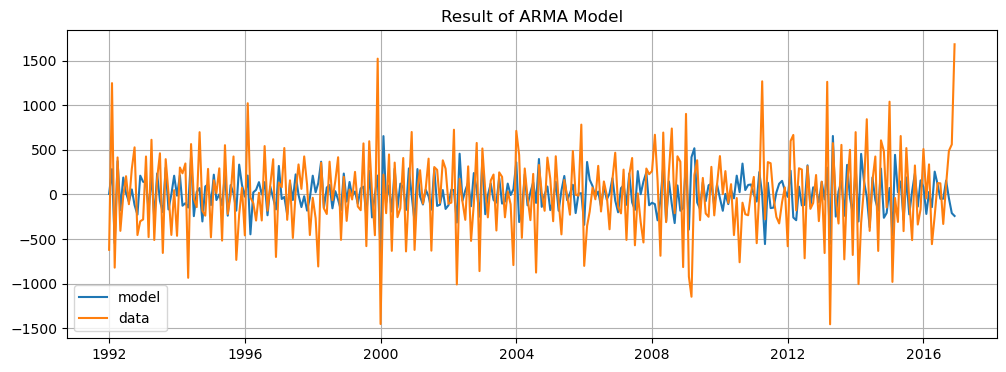

In [129]:
### Let's predict using the ARMa model. Let us predict the hist first:
arma = ARIMA(residue,order=(1,0,0)).fit()
arma_hist_preds = arma.predict()


plt.figure(figsize = (12, 4))
plt.plot(arma_hist_preds, label = 'model')
plt.plot(residue, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

In [130]:
### Now with the model, let us predict the residue on the future data: 
yhat_residue = arma.forecast(steps=len(y_future))

yhat_residue

2017-01-01   -740.271244
2017-02-01    337.182339
2017-03-01   -142.078715
2017-04-01     71.100917
2017-05-01    -23.723303
                 ...    
2022-11-01      5.469945
2022-12-01      5.469945
2023-01-01      5.469945
2023-02-01      5.469945
2023-03-01      5.469945
Freq: MS, Name: predicted_mean, Length: 75, dtype: float64

In [131]:
### Let us get our final timeseries prediction: predicted trend + predicted seasonal + prediccted residue: 
yhat = yhat_seasonal+yhat_trend+yhat_residue

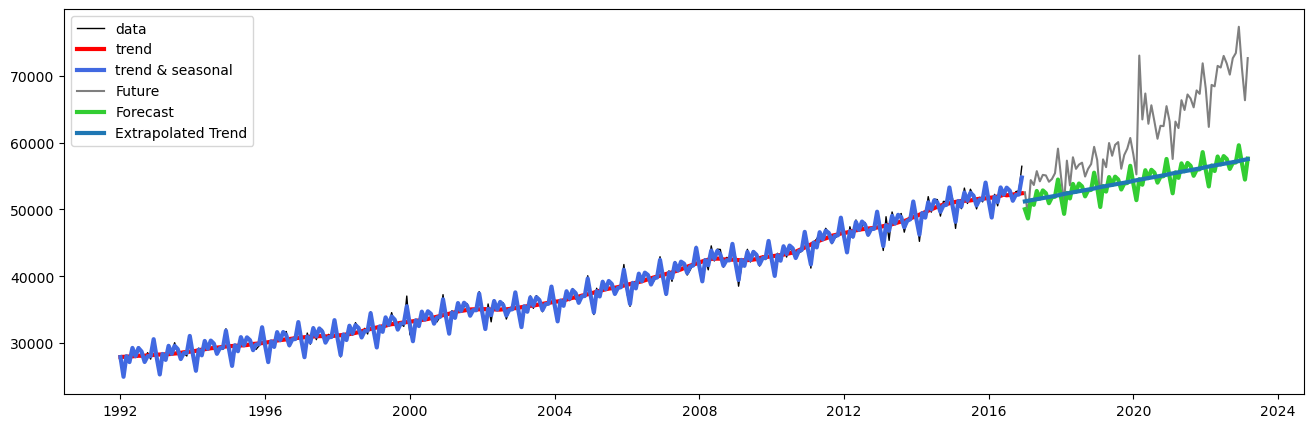

In [132]:
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data', linewidth=1)
plt.plot(trend, label='trend', linewidth=3, color=[1,0,0])
plt.plot(season_and_trend, label='trend & seasonal', color='royalblue', linewidth=3)
plt.plot(y_future, 'k', alpha=0.5, label='Future')
plt.plot(yhat, label='Forecast', color='limegreen', linewidth=3)
plt.plot(y_future_ds['Date'], trend_predicted, linewidth=3, label='Extrapolated Trend')
plt.legend()

mmm! The addition of predicted residue does not seem to have helped much. <br />
Let us see the prediction errors:

In [133]:
pred_error = y_future - yhat

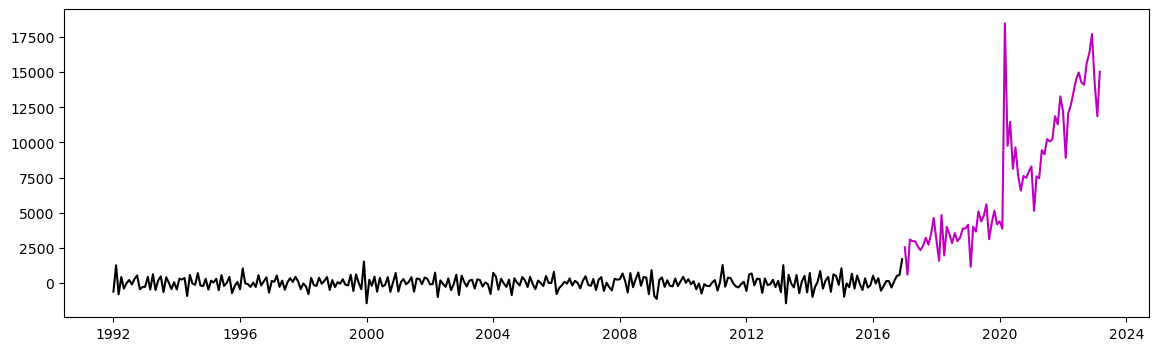

In [134]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k')
plt.plot(pred_error,'m')

In [135]:
### Size of the prediction error
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
prediction_errors.append(['Time Series - LR Projected Trend W/ Residue', MAEp, RMSEp])
prediction_errors

[['Time Series - Flat Trend Projected', 9233.930980362238, 11175.237915076861],
 ['Time Series - LR Projected Trend W/O Residue',
  7295.517158813891,
  8631.105856181324],
 ['Time Series - LR Projected Trend W/ Residue',
  7296.9292421885675,
  8629.069746887895]]

#### Unfortunately, predicting the residue did not improve the score of the model. 

## Linear Regression

Let us try a simple Linear regression for our problem and see if it is any better at predicting the time series

In [136]:
y_hist_ds = pd.DataFrame(y_hist)
y_future_ds = pd.DataFrame(y_future)

#Let's break down the date into Year, Month, and Day columns
y_hist_ds.reset_index(inplace=True)
y_hist_ds['year'] = y_hist_ds['Date'].dt.year
y_hist_ds['month'] = y_hist_ds['Date'].dt.month
y_hist_ds['day'] = y_hist_ds['Date'].dt.day

y_future_ds.reset_index(inplace=True)
y_future_ds['year'] = y_future_ds['Date'].dt.year
y_future_ds['month'] = y_future_ds['Date'].dt.month
y_future_ds['day'] = y_future_ds['Date'].dt.day


In [137]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

In [138]:
### Let us get the training and test data sets
X_train = y_hist_ds[['year', 'month', 'day']]
X_test = y_future_ds[['year', 'month', 'day']]
y_train = y_hist_ds['Value']
y_test = y_future_ds['Value']


In [139]:
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

params = {
    'poly__degree': [1,2,3,4,5,6,7,8,9,10]
}

grid = GridSearchCV(pipe, param_grid=params)
grid.fit(X_train, y_train)
print(f'Best Params: {grid.best_params_}')


Best Params: {'poly__degree': 7}


Cross validation seems to recommend using a degree 7 polynomial regression for our case. Let us try that: 

In [140]:
best_degree = grid.best_params_["poly__degree"]

In [141]:
# Cross Validation recommends that we use a degree 7 model. Let us try that
poly = PolynomialFeatures(degree=best_degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
model = LinearRegression().fit(X_poly_train, y_train)

In [142]:
# Now, let's evaluate performance on testing set
y_pred = model.predict(X_poly_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE on testing set:", mse)

MSE on testing set: 24608795.579485383


In [143]:
# Now that we know the best dgree to use, let us train our final model to that degree: 
poly = PolynomialFeatures(degree=best_degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
model = LinearRegression().fit(X_poly_train, y_train)

# Evaluate performance on testing set
y_pred = model.predict(X_poly_test)
mse = mean_squared_error(y_test, y_pred)
print("Selected degree:", best_degree)
print("MSE on testing set:", mse)

Selected degree: 7
MSE on testing set: 24608795.579485383


In [144]:
lr_pred_error = y_test - y_pred
### Size of the prediction error using Linear Regression
MAEp = np.abs(lr_pred_error).mean()
RMSEp = np.sqrt( np.square(lr_pred_error).mean() )
MAEp, RMSEp

(3588.4166460931797, 4960.7253078038275)

In [145]:
lr_ds = pd.DataFrame(y_future)
lr_ds = lr_ds.rename(columns={'Value': 'hist_value'})
lr_ds['predicted_value'] = y_pred
lr_ds

,hist_value,predicted_value
Date,,
2017-01-01,52566,53389.962896
2017-02-01,49226,51386.096196
2017-03-01,54383,52475.509404
2017-04-01,53651,53922.273931
2017-05-01,55724,54769.890142
...,...,...
2022-11-01,73388,62700.767949
2022-12-01,77309,65673.776738
2023-01-01,71172,63752.699102


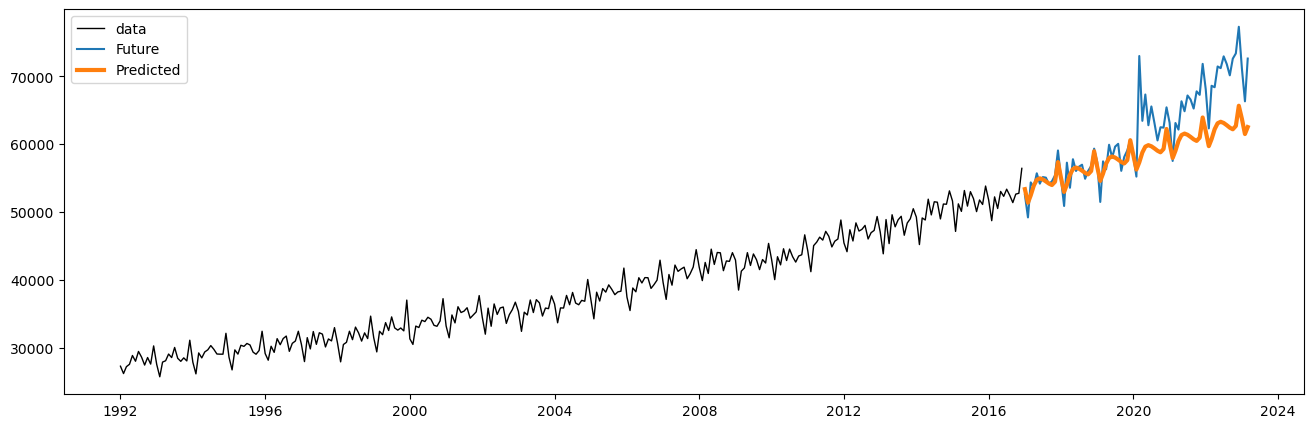

In [146]:
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label='data', linewidth=1)
plt.plot(y_future, label='Future')
plt.plot(lr_ds['predicted_value'], linewidth=3, label='Predicted')
plt.legend()

We can already see that our Linear Regression model seems to have a much better prediction that the time series

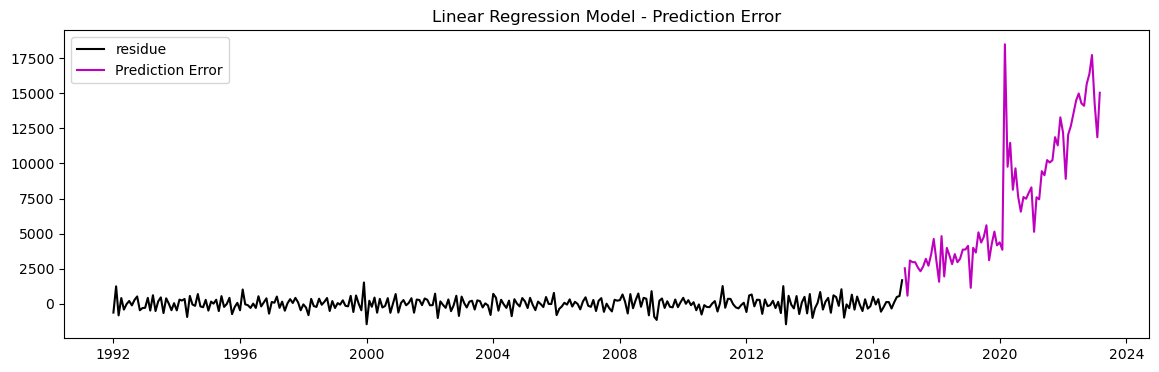

In [147]:
lr_yhat = lr_ds['predicted_value']
lr_pred_error = y_future - lr_yhat
plt.figure(figsize=(14,4))
plt.plot(residue,'k', label='residue')
plt.plot(pred_error,'m', label='Prediction Error')
plt.title('Linear Regression Model - Prediction Error')
plt.legend()

In [148]:
### Size of the prediction error
MAEp = np.abs(lr_pred_error).mean()
RMSEp = np.sqrt( np.square(lr_pred_error).mean() )
prediction_errors.append(['Linear Regression', MAEp, RMSEp])
prediction_errors

[['Time Series - Flat Trend Projected', 9233.930980362238, 11175.237915076861],
 ['Time Series - LR Projected Trend W/O Residue',
  7295.517158813891,
  8631.105856181324],
 ['Time Series - LR Projected Trend W/ Residue',
  7296.9292421885675,
  8629.069746887895],
 ['Linear Regression', 3588.4166460931797, 4960.7253078038275]]

Let us now plot the errors in order to compare the different models

In [149]:
errors_df = pd.DataFrame(prediction_errors, columns=['Algorithm', 'Mean Absolute Error', 'Root Mean Square Error'])
errors_df

,Algorithm,Mean Absolute Error,Root Mean Square Error
0,Time Series - Flat Trend Projected,9233.930980,11175.237915
1,Time Series - LR Projected Trend W/O Residue,7295.517159,8631.105856
2,Time Series - LR Projected Trend W/ Residue,7296.929242,8629.069747
3,Linear Regression,3588.416646,4960.725308


In [151]:
len(prediction_errors)

4

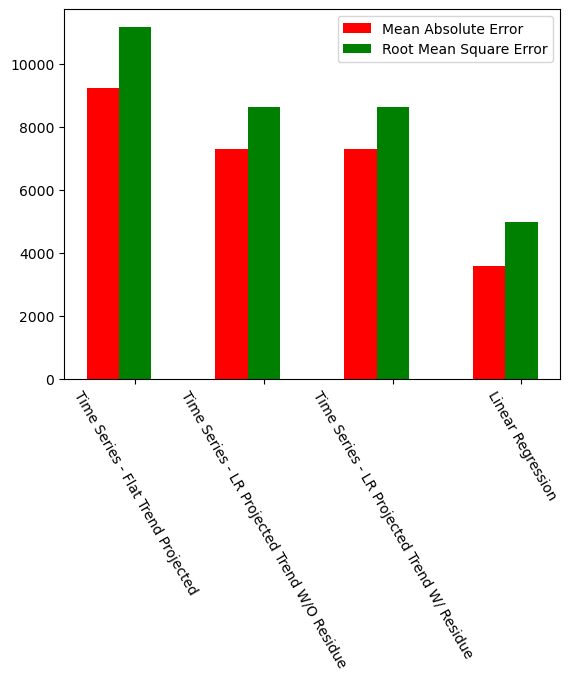

In [158]:
import matplotlib.pyplot as plt
barWidth = 0.25
# Set position of bar on X axis
br1 = np.arange(len(prediction_errors))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, errors_df['Mean Absolute Error'], color='red', width = barWidth, label='Mean Absolute Error')
plt.bar(br2, errors_df['Root Mean Square Error'], color='green', width = barWidth, label='Root Mean Square Error')

# Add XTicks to plot
plt.xticks([r + barWidth for r in range(len(prediction_errors))], errors_df['Algorithm'], rotation=300)

plt.legend()

### Conclusion

<b>Here are the my main findings from the project: </b>
* Assuming that the trend line will flatten into the future is an invalid assumption. We saw that the errors are the highest with the model built using this assumption. 
* Using Linear Regression to project the trend line into the future and building a time series based on that was much more beneficial. The errors reduced by a factor of ~ 20% when compared to the flat trend line model. 
* Including the ARMA model's projected residue into the model had no affecct. The errors remained the same. 
* The biggest surprise of the project was that <span style="color:yellow">Linear Regression performed the best</span> out of all the models. Its errors were <u>nearly half</u> of the Time series model.   
